In [1]:
import torch
from transformers import AutoModel,AutoConfig,AutoTokenizer,AutoModelForSequenceClassification,Trainer,TrainingArguments,DataCollatorWithPadding
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
import evaluate
import re
from pygtrans import Translate

In [2]:
%%time
# 加载数据
excel_file = 'd:/基于深度学习的海量文本处理/第1阶段/10w.xlsx'
data_frame = pd.read_excel(excel_file)

Wall time: 19.6 s


In [3]:
# # 随机抽样（预实验使用）
# data_frame = data_frame.sample(n=30)
# data_frame

In [4]:
# 停用词预处理
stop_words = ['您好','你好',':很高兴为您服务','请问有什么可以帮您','client','user',' ']
sep_words = ['。', '!', '?', ',']
def ProcessStopWords(text):
    for word in stop_words:
        text = text.replace(word,'')
    text = text.replace(':','。').replace('。','',1) # 删除第一个。
    # for word in sep_words:
    #     text = text.replace(word, '[SEP]')
    return text

data_frame['转写文本'] = data_frame['转写文本'].map(ProcessStopWords)

In [5]:
data_frame['转写文本'].iloc[0]

'哎我想问一下,我这个一三九的号码那个扣费方式是怎么样的。扣费方式的话它是每个月呢就是每个月的一个基本月租,49.7元,然后的话加上您的副卡十块钱,然后的话每个月就是五十九块七毛钱这样子的一个月,月租每个月1,一号再这样子扣月。不是我是问是从那个,银行里面因为是这样子我是从联,呃移动刚刚转过来的我以前绑定的是,建行的那个什么银行卡,是先付费后扣,给我扣款,我想问一下就是这么转过来了你那里有,我的那个什么,银行扣款方式吗还是。没有的。那我这个话费怎么交呢。话费的话您直接在app上面进行一个充值就可以了。是先付费还是后付费的。先付费的,哦。我这个,呃号码现在有充钱吗。这边的话查询到除了,这个月没有的然后的话看到您,最近1期充值就是在11月,月份的1号充的。充了多少钱呢。两百块钱。哦现在还有余额多少呢。二十块七毛五。哦就是每个月我自己就是在,App上查然后不够了我就充钱是吗。嗯是的。那你们有那个什么欠费提醒吗。哦这边都是会有短信这边提醒的。这边还有什么可以帮您呢。没有了好谢谢那您稍后收到短信回复一下数字1,谢谢您再见'

In [6]:
# 标签预处理
regex = re.compile(r'^.*?>(.*?)>.*?$')
def ProcessLabels(text):
    text = text.replace('>>','>').replace('10019','')
    text = re.match(regex, text).groups()[0]
    return text

data_frame['服务请求'] = data_frame['服务请求'].map(ProcessLabels)

In [7]:
# 预览预处理结果
data_frame['转写文本'].iloc[:10]

0    哎我想问一下,我这个一三九的号码那个扣费方式是怎么样的。扣费方式的话它是每个月呢就是每个月的...
1    喂我那个宽带不能用。宽带故障了是吗。哦现在不能用前前几天就不能用了。稍等我帮您看一下。嗯稍等...
2    哎我我办理这个那个我想问一下我这个号码有没有开通5g套餐呀。我看一下您这里有开通5g业务可以...
3    请不要挂机您拨叫的用户正在通话中请唔好挂机您拨叫凯用户正在通话中。。嗯由于您多次没有声音我将...
4    喂我想咨询一下我的那个联通卡怎么回事啊,我都没用过。嗯您可以提供一下吗。这个号码就是我我号码...
5    嗯我想问一下我这个卡是啊升了5g上次是帮我升了5g然后现在是月租是54.5元上网费又是30一...
6                                               不要我有卡。
7    我的号码为啥暂暂停服务了。稍等一下。我帮您看了一下的话您之前的话有反映过这个问题的是吧。然后...
8    哎你查一下我这个话费还有余额吗。您这边还有8.95元。怎么打不了怎么没有信号呢网络没有了呢。...
9    哎先生。哦。嗯我想问一下现在如果这个号码要补号码的话那个身份证复印件有没有有效的。补卡补卡要...
Name: 转写文本, dtype: object

In [8]:
# 训练复盘并分析数据集后，考虑在前面的处理把 样本数<1000 的剔除，即剔除下列：
rm_labels = ['临时','其他','商机','资料信息','业务变更问题','投诉','故障']
for rm_label in rm_labels:
    data_frame.drop(data_frame[data_frame.服务请求 == rm_label].index, inplace=True)
data_frame

,接触ID,用户号码,来电时间,服务请求,转写文本
0,202301111449223447862S1,13924661819,2023-01-11 14:49:25,查询,"哎我想问一下,我这个一三九的号码那个扣费方式是怎么样的。扣费方式的话它是每个月呢就是每个月的..."
1,2023011214193335844424S1,15817930939,2023-01-12 14:19:37,不满,喂我那个宽带不能用。宽带故障了是吗。哦现在不能用前前几天就不能用了。稍等我帮您看一下。嗯稍等...
2,2023011117584374443240S1,18682452380,2023-01-11 17:58:48,咨询,哎我我办理这个那个我想问一下我这个号码有没有开通5g套餐呀。我看一下您这里有开通5g业务可以...
3,2023011111224925142885S1,17520581290,2023-01-11 11:22:53,无效来话,请不要挂机您拨叫的用户正在通话中请唔好挂机您拨叫凯用户正在通话中。。嗯由于您多次没有声音我将...
4,2023011116155634245935S1,18929735508,2023-01-11 16:16:00,无效来话,"喂我想咨询一下我的那个联通卡怎么回事啊,我都没用过。嗯您可以提供一下吗。这个号码就是我我号码..."
...,...,...,...,...,...
99995,2023011518563077444424S1,13192805729,2023-01-15 18:56:34,咨询,呃你你帮我查一下我这个卡是是办了个流流量王卡吗怎么会饿这这1天不到就扣了23块多是怎么扣的了...
99996,2023011312500975848096S1,17666518437,2023-01-13 12:50:14,不满,喂。我那个啥我那个有个流量扣我30块钱咋扣的。流量扣费嘛那是十二月份的。啊应该是吧十二月份还...
99997,2023011214322475442931S1,18588258108,2023-01-12 14:32:28,办理,哎我问一下就是我之前好像你们有跟我说我有一个什么宽带可以。把。什么优惠还是怎么考虑。安装。对...
99998,2023011212102419845872S1,18582242369,2023-01-12 12:10:28,查询,"哎,我想问一下,我那个我那个,怎么有个20多块钱的那个增值业务是什么。是您来电这一个号码吗。..."


In [9]:
# 翻译转写文本
client = Translate(target='en')
temp = np.array([])

In [10]:
# 测试
pd.DataFrame(np.array([trans_res.translatedText for trans_res in client.translate(np.array(data_frame['转写文本'].iloc[0:2]).tolist())]))

,0
0,"Hey, I want to ask what the deduction method i..."
1,"Hey, my broadband doesn&#39;t work. Is the bro..."


In [11]:
total_num = data_frame.shape[0]
batch = 100
epoch = int(total_num/batch)
print(f'共{epoch}部分')
for i in range(epoch):
    if not i == epoch - 1:
        print(f'{i}部分开始')
        translated_res = [trans_res.translatedText for trans_res in client.translate(np.array(data_frame['转写文本'].iloc[i*batch:(i+1)*batch]).tolist())]
    else:
        print('最后一轮开始')
        translated_res = [trans_res.translatedText for trans_res in client.translate(np.array(data_frame['转写文本'].iloc[i*batch:]).tolist())]
    
    translated_res = np.array(translated_res)
    temp =  np.concatenate((temp, translated_res), axis=0)
    print(f'第{i}部分已完成')

共999部分
0部分开始
第0部分已完成
1部分开始
第1部分已完成
2部分开始
第2部分已完成
3部分开始
第3部分已完成
4部分开始
第4部分已完成
5部分开始
第5部分已完成
6部分开始
第6部分已完成
7部分开始
第7部分已完成
8部分开始
第8部分已完成
9部分开始
第9部分已完成
10部分开始
第10部分已完成
11部分开始
第11部分已完成
12部分开始
第12部分已完成
13部分开始
第13部分已完成
14部分开始
第14部分已完成
15部分开始
第15部分已完成
16部分开始
第16部分已完成
17部分开始
第17部分已完成
18部分开始
第18部分已完成
19部分开始
第19部分已完成
20部分开始
第20部分已完成
21部分开始
第21部分已完成
22部分开始
第22部分已完成
23部分开始
第23部分已完成
24部分开始
第24部分已完成
25部分开始
第25部分已完成
26部分开始
第26部分已完成
27部分开始
第27部分已完成
28部分开始
第28部分已完成
29部分开始
第29部分已完成
30部分开始
第30部分已完成
31部分开始
第31部分已完成
32部分开始
第32部分已完成
33部分开始
第33部分已完成
34部分开始
第34部分已完成
35部分开始
第35部分已完成
36部分开始
第36部分已完成
37部分开始
第37部分已完成
38部分开始
第38部分已完成
39部分开始
第39部分已完成
40部分开始
第40部分已完成
41部分开始
第41部分已完成
42部分开始
第42部分已完成
43部分开始
第43部分已完成
44部分开始
第44部分已完成
45部分开始
第45部分已完成
46部分开始
第46部分已完成
47部分开始
第47部分已完成
48部分开始
第48部分已完成
49部分开始
第49部分已完成
50部分开始
第50部分已完成
51部分开始
第51部分已完成
52部分开始
第52部分已完成
53部分开始
第53部分已完成
54部分开始
第54部分已完成
55部分开始
第55部分已完成
56部分开始
第56部分已完成
57部分开始
第57部分已完成
58部分开始
第58部分已完成
59部分开始
第59部分已完成
60部分开始
第60部分已完成
61部分开始
第61部分已完成
62部分开始
第62部分已完成
63部分开

第467部分已完成
468部分开始
第468部分已完成
469部分开始
第469部分已完成
470部分开始
第470部分已完成
471部分开始
第471部分已完成
472部分开始
第472部分已完成
473部分开始
第473部分已完成
474部分开始
第474部分已完成
475部分开始
第475部分已完成
476部分开始
第476部分已完成
477部分开始
第477部分已完成
478部分开始
第478部分已完成
479部分开始
第479部分已完成
480部分开始
第480部分已完成
481部分开始
第481部分已完成
482部分开始
第482部分已完成
483部分开始
第483部分已完成
484部分开始
第484部分已完成
485部分开始
第485部分已完成
486部分开始
第486部分已完成
487部分开始
第487部分已完成
488部分开始
第488部分已完成
489部分开始
第489部分已完成
490部分开始
第490部分已完成
491部分开始
第491部分已完成
492部分开始
第492部分已完成
493部分开始
第493部分已完成
494部分开始
第494部分已完成
495部分开始
第495部分已完成
496部分开始
第496部分已完成
497部分开始
第497部分已完成
498部分开始
第498部分已完成
499部分开始
第499部分已完成
500部分开始
第500部分已完成
501部分开始
第501部分已完成
502部分开始
第502部分已完成
503部分开始
第503部分已完成
504部分开始
第504部分已完成
505部分开始
第505部分已完成
506部分开始
第506部分已完成
507部分开始
第507部分已完成
508部分开始
第508部分已完成
509部分开始
第509部分已完成
510部分开始
第510部分已完成
511部分开始
第511部分已完成
512部分开始
第512部分已完成
513部分开始
第513部分已完成
514部分开始
第514部分已完成
515部分开始
第515部分已完成
516部分开始
第516部分已完成
517部分开始
第517部分已完成
518部分开始
第518部分已完成
519部分开始
第519部分已完成
520部分开始
第520部分已完成
521部分开始
第521部分已完成
522部分开始
第522部分已完成


第923部分已完成
924部分开始
第924部分已完成
925部分开始
第925部分已完成
926部分开始
第926部分已完成
927部分开始
第927部分已完成
928部分开始
第928部分已完成
929部分开始
第929部分已完成
930部分开始
第930部分已完成
931部分开始
第931部分已完成
932部分开始
第932部分已完成
933部分开始
第933部分已完成
934部分开始
第934部分已完成
935部分开始
第935部分已完成
936部分开始
第936部分已完成
937部分开始
第937部分已完成
938部分开始
第938部分已完成
939部分开始
第939部分已完成
940部分开始
第940部分已完成
941部分开始
第941部分已完成
942部分开始
第942部分已完成
943部分开始
第943部分已完成
944部分开始
第944部分已完成
945部分开始
第945部分已完成
946部分开始
第946部分已完成
947部分开始
第947部分已完成
948部分开始
第948部分已完成
949部分开始
第949部分已完成
950部分开始
第950部分已完成
951部分开始
第951部分已完成
952部分开始
第952部分已完成
953部分开始
第953部分已完成
954部分开始
第954部分已完成
955部分开始
第955部分已完成
956部分开始
第956部分已完成
957部分开始
第957部分已完成
958部分开始
第958部分已完成
959部分开始
第959部分已完成
960部分开始
第960部分已完成
961部分开始
第961部分已完成
962部分开始
第962部分已完成
963部分开始
第963部分已完成
964部分开始
第964部分已完成
965部分开始
第965部分已完成
966部分开始
第966部分已完成
967部分开始
第967部分已完成
968部分开始
第968部分已完成
969部分开始
第969部分已完成
970部分开始
第970部分已完成
971部分开始
第971部分已完成
972部分开始
第972部分已完成
973部分开始
第973部分已完成
974部分开始
第974部分已完成
975部分开始
第975部分已完成
976部分开始
第976部分已完成
977部分开始
第977部分已完成
978部分开始
第978部分已完成


In [12]:
translated_res = temp
len(translated_res)

99939

In [13]:
# 加入翻译
# data_frame = data_frame.drop(columns=['translated_text'])
data_frame.insert(0, 'translated_text', value=translated_res)

In [14]:
# 处理翻译出错的符号
def Finetune_translate(text):
    text = text.replace('&#39;','\'')
    return text
    
data_frame['translated_text'] = data_frame['translated_text'].map(Finetune_translate)
data_frame[:10]

,translated_text,接触ID,用户号码,来电时间,服务请求,转写文本
0,"Hey, I want to ask what the deduction method i...",202301111449223447862S1,13924661819,2023-01-11 14:49:25,查询,"哎我想问一下,我这个一三九的号码那个扣费方式是怎么样的。扣费方式的话它是每个月呢就是每个月的..."
1,"Hey, my broadband doesn't work. Is the broadba...",2023011214193335844424S1,15817930939,2023-01-12 14:19:37,不满,喂我那个宽带不能用。宽带故障了是吗。哦现在不能用前前几天就不能用了。稍等我帮您看一下。嗯稍等...
2,"Hey, I'm applying for this and that. I want to...",2023011117584374443240S1,18682452380,2023-01-11 17:58:48,咨询,哎我我办理这个那个我想问一下我这个号码有没有开通5g套餐呀。我看一下您这里有开通5g业务可以...
3,Please do not hang up. The user you are callin...,2023011111224925142885S1,17520581290,2023-01-11 11:22:53,无效来话,请不要挂机您拨叫的用户正在通话中请唔好挂机您拨叫凯用户正在通话中。。嗯由于您多次没有声音我将...
4,"Hello, I would like to ask what happened to my...",2023011116155634245935S1,18929735508,2023-01-11 16:16:00,无效来话,"喂我想咨询一下我的那个联通卡怎么回事啊,我都没用过。嗯您可以提供一下吗。这个号码就是我我号码..."
5,"Well, I would like to ask if my card was upgra...",2023011211202452445985S1,13268380631,2023-01-12 11:20:29,查询,嗯我想问一下我这个卡是啊升了5g上次是帮我升了5g然后现在是月租是54.5元上网费又是30一...
6,Don't want me to have a card.,2023011221392818042574S1,18507625784,2023-01-12 21:41:50,不满,不要我有卡。
7,Why is my number temporarily suspended? Wait a...,2023011119235563644186S1,18575338828,2023-01-11 19:23:59,不满,我的号码为啥暂暂停服务了。稍等一下。我帮您看了一下的话您之前的话有反映过这个问题的是吧。然后...
8,"Hey, please check if I still have balance on m...",2023011214073176245834S1,13106672198,2023-01-12 14:07:36,不满,哎你查一下我这个话费还有余额吗。您这边还有8.95元。怎么打不了怎么没有信号呢网络没有了呢。...
9,"Hey sir. oh. Well, I would like to ask if the ...",2023011106133663642968S1,13215222179,2023-01-11 14:13:39,查询,哎先生。哦。嗯我想问一下现在如果这个号码要补号码的话那个身份证复印件有没有有效的。补卡补卡要...


In [15]:
prompts = np.array(data_frame['translated_text'])
choices = np.array(data_frame['服务请求'])

In [16]:
data_frame['服务请求']

0          查询
1          不满
2          咨询
3        无效来话
4        无效来话
         ... 
99995      咨询
99996      不满
99997      办理
99998      查询
99999      办理
Name: 服务请求, Length: 99939, dtype: object

In [17]:
# 取最大长度
data_frame.insert(data_frame.shape[1], 'text_len',None)
data_frame['text_len'] = data_frame['translated_text'].map(len)
max_length_index = data_frame['text_len'].argmax()
max_length = data_frame['text_len'].iloc[max_length_index]
max_length_index, max_length

(72847, 14061)

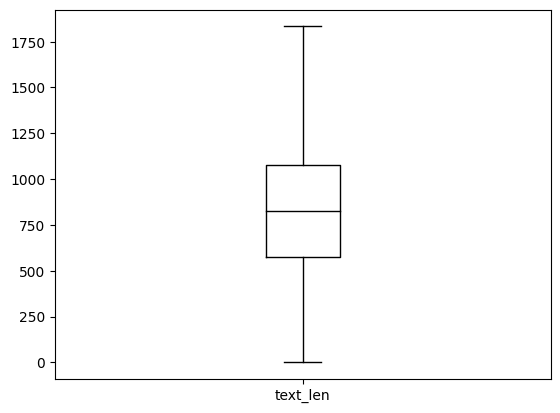

In [18]:
# 观察文本长度分布（排除异常值）
data_frame.boxplot('text_len', grid=False, showfliers=False, color='Black')
plt.suptitle("")
plt.xlabel("")
plt.show()
# 由图可知，取512足够覆盖正常样本
max_length = 512

In [19]:
# 去重choices，并保存原choices对应去重后的位置
unique_choices = np.unique(choices)
labels = np.array([np.argwhere(unique_choices==v)[0]  for v in choices])
unique_choices.shape, labels.shape

((5,), (99939, 1))

In [20]:
# 加入标签
data_frame.insert(0, 'label', value=labels)
data_frame[:10]

,label,translated_text,接触ID,用户号码,来电时间,服务请求,转写文本,text_len
0,4,"Hey, I want to ask what the deduction method i...",202301111449223447862S1,13924661819,2023-01-11 14:49:25,查询,"哎我想问一下,我这个一三九的号码那个扣费方式是怎么样的。扣费方式的话它是每个月呢就是每个月的...",1473
1,0,"Hey, my broadband doesn't work. Is the broadba...",2023011214193335844424S1,15817930939,2023-01-12 14:19:37,不满,喂我那个宽带不能用。宽带故障了是吗。哦现在不能用前前几天就不能用了。稍等我帮您看一下。嗯稍等...,1604
2,2,"Hey, I'm applying for this and that. I want to...",2023011117584374443240S1,18682452380,2023-01-11 17:58:48,咨询,哎我我办理这个那个我想问一下我这个号码有没有开通5g套餐呀。我看一下您这里有开通5g业务可以...,702
3,3,Please do not hang up. The user you are callin...,2023011111224925142885S1,17520581290,2023-01-11 11:22:53,无效来话,请不要挂机您拨叫的用户正在通话中请唔好挂机您拨叫凯用户正在通话中。。嗯由于您多次没有声音我将...,259
4,3,"Hello, I would like to ask what happened to my...",2023011116155634245935S1,18929735508,2023-01-11 16:16:00,无效来话,"喂我想咨询一下我的那个联通卡怎么回事啊,我都没用过。嗯您可以提供一下吗。这个号码就是我我号码...",1120
5,4,"Well, I would like to ask if my card was upgra...",2023011211202452445985S1,13268380631,2023-01-12 11:20:29,查询,嗯我想问一下我这个卡是啊升了5g上次是帮我升了5g然后现在是月租是54.5元上网费又是30一...,651
6,0,Don't want me to have a card.,2023011221392818042574S1,18507625784,2023-01-12 21:41:50,不满,不要我有卡。,29
7,0,Why is my number temporarily suspended? Wait a...,2023011119235563644186S1,18575338828,2023-01-11 19:23:59,不满,我的号码为啥暂暂停服务了。稍等一下。我帮您看了一下的话您之前的话有反映过这个问题的是吧。然后...,673
8,0,"Hey, please check if I still have balance on m...",2023011214073176245834S1,13106672198,2023-01-12 14:07:36,不满,哎你查一下我这个话费还有余额吗。您这边还有8.95元。怎么打不了怎么没有信号呢网络没有了呢。...,704
9,4,"Hey sir. oh. Well, I would like to ask if the ...",2023011106133663642968S1,13215222179,2023-01-11 14:13:39,查询,哎先生。哦。嗯我想问一下现在如果这个号码要补号码的话那个身份证复印件有没有有效的。补卡补卡要...,269


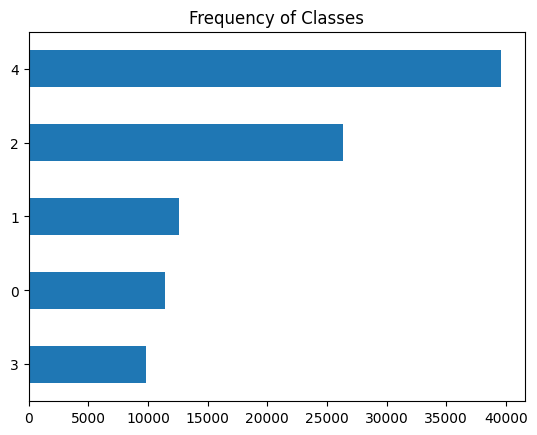

In [25]:
# 取出特征与labels
df = data_frame[['label', 'translated_text', '服务请求']]
df[:10]
# 统计
df['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [22]:
# # 手动处理样本非均衡情况
# df4 = df[df['label'] == 4].sample(n=30000)
# df2 = df[df['label'] == 2]
# df1 = pd.DataFrame(np.repeat(df[df['label'] == 1].values, 2, axis=0), columns=df.columns)
# df0 = pd.DataFrame(np.repeat(df[df['label'] == 0].values, 2, axis=0), columns=df.columns)
# df3 = pd.DataFrame(np.repeat(df[df['label'] == 3].values, 2, axis=0), columns=df.columns)

# df = pd.concat([df0, df1, df2, df3, df4], ignore_index=True)

In [23]:
# 先排序 label，以便后续充分打乱
df = df.sort_values(by='服务请求')

In [24]:
save_excel_path = './PreProcess.xlsx'
df.to_excel(save_excel_path) # 保存翻译结果，方便重复使用
df

,label,translated_text,服务请求
39891,0,"Hey, that is my account. The current network i...",不满
58762,0,"How can I help you. Hey, let's see if my numbe...",不满
83666,0,Have the issues I reported not been resolved y...,不满
10780,0,". Sorry, my number is blocked. Sir, please hol...",不满
83661,0,I would like to ask if there is anything I can...,不满
...,...,...,...
23694,4,"Ah, I want to check how much my package is. I'...",查询
23693,4,"Hey, I want to check the cards in my name. Wha...",查询
64200,4,Check the traffic. Your current traffic is sti...,查询
64185,4,"Uh, hey, is my internet traffic turned off? Oh...",查询


In [26]:
# 创建数据集
ds = DatasetDict({'train': Dataset.from_pandas(df)})
# ds['train'] = ds['train'].rename_column('转写文本','text')
ds = ds.remove_columns(['服务请求'])

ds['train'] = ds['train'].rename_columns({'translated_text':'text'})
ds = ds['train'].train_test_split(0.2, shuffle=True) # 按 8:2 分割数据集
ds, ds['train'][0], ds['test'][0]

(DatasetDict({
     train: Dataset({
         features: ['label', 'text', '__index_level_0__'],
         num_rows: 79951
     })
     test: Dataset({
         features: ['label', 'text', '__index_level_0__'],
         num_rows: 19988
     })
 }),
 {'label': 2,
  'text': 'Hello, this is my phone number. I want to log out. Let’s take a look. Er, caller number, if you want to cancel your account, you can make an appointment to cancel your account through the China Unicom app. Well, because I have a balance plan and I still have money on this mobile phone number, you need to transfer it to another number for me. I called him last time and he said that if I want to cancel, I can just call him. Please wait. Well, before, you also reported a problem about account cancellation, and you were told to keep it in use, and now you want to cancel the account, right? Um. Ah, yes, yes. Okay please wait a moment. Here again, I will help you record your feedback. Please note that the call will be answer

In [27]:
%%time
model_path = './bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_path)
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=max_length)

tokenized_ds = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/79951 [00:00<?, ? examples/s]

Map:   0%|          | 0/19988 [00:00<?, ? examples/s]

Wall time: 29.8 s


In [28]:
# 模型
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # 允许不同长度tensor的存在
model_config = AutoConfig.from_pretrained(model_path)
model_config.num_labels = unique_choices.shape[0]
model = AutoModelForSequenceClassification.from_config(model_config)

In [29]:
tokenized_ds['train'][0]

{'label': 2,
 'text': 'Hello, this is my phone number. I want to log out. Let’s take a look. Er, caller number, if you want to cancel your account, you can make an appointment to cancel your account through the China Unicom app. Well, because I have a balance plan and I still have money on this mobile phone number, you need to transfer it to another number for me. I called him last time and he said that if I want to cancel, I can just call him. Please wait. Well, before, you also reported a problem about account cancellation, and you were told to keep it in use, and now you want to cancel the account, right? Um. Ah, yes, yes. Okay please wait a moment. Here again, I will help you record your feedback. Please note that the call will be answered within 24 hours. Yeah okay okay. OK, do you have any other inquiries? Ah no more. Well, thank you for calling me. I wish you a happy life. Goodbye.',
 '__index_level_0__': 4640,
 'input_ids': [101,
  8667,
  117,
  1142,
  1110,
  1139,
  2179,
 

In [30]:
# 评估
accuracy = evaluate.load('./evaluate/metrics/accuracy/accuracy.py')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [31]:
# Adam 训练阶段
training_args = TrainingArguments('./output',evaluation_strategy='epoch',save_strategy='epoch', learning_rate=5e-7, 
                                    load_best_model_at_end=True, num_train_epochs=3, use_cpu=True)
trainer = Trainer(model, args=training_args, train_dataset=tokenized_ds['train'], eval_dataset=tokenized_ds['test'], 
                  tokenizer=tokenizer, data_collator=data_collator, compute_metrics=compute_metrics)

In [32]:
%%time
# 训练
trainer.train(resume_from_checkpoint=False)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# SGD 训练阶段
ds = ds.shuffle(88) # 再次打乱数据集
optimizer = torch.optim.SGD(model.parameters(), lr=5e-9)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch+1))
training_args = TrainingArguments('./output',evaluation_strategy='epoch',save_strategy='epoch',
                                load_best_model_at_end=True, num_train_epochs=5)
trainer = Trainer(model, args=training_args, train_dataset=tokenized_ds['train'], eval_dataset=tokenized_ds['test'], 
                  tokenizer=tokenizer, data_collator=data_collator, 
                  compute_metrics=compute_metrics, optimizers=(optimizer, lr_scheduler))

In [ ]:
%%time
# 精准训练
trainer.train(resume_from_checkpoint=False)